# Lights Out

Amongst the various logic and combinatorial puzzles, the classic game of Lights Out presents a unique strategic
challenge. The goal of the puzzle is to transform a grid of lights – where each light can be toggled between on and
off – into a state where all lights are turned off. This deceptively simple problem requires careful planning and
systematic decision-making (Fleischer & Yu, 2013). Hence, we believe that artificial intelligence (AI) agents offer
a powerful tool to analyse this puzzle – to explore potential solutions and discover the optimal sequence of toggles
to solve it.

In [116]:
import numpy as np
from PIL import Image
from IPython.display import display
import queue
import copy
import heapq

Number of Lights On: 5


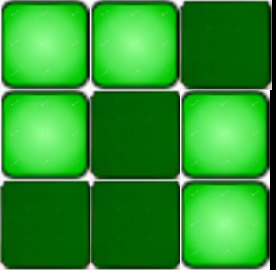

In [137]:
# seed game
np.random.seed(1234) 

class LightsOutGame:
    """ 
    Implementation of Lights Out game using a 2D array
    """

    def __init__(self, M, N):
        # game grid size
        self._M = M
        self._N = N
        self._game_grid = np.random.choice([0, 1], size=(self._M, self._N)) # initialise game grid
        self._num_lights = np.count_nonzero(self._game_grid == 1)
        self._adj_dir = [[0, 0], [-1, 0], [1, 0], [0, -1], [0, 1]] # direction of tiles whether bits need to be flipped on click
        self.click_path = []
        self.key = self._gen_key()

    def click(self, x_pos, y_pos):
        if self.has_ended():
            return
        
        # keep track of what we click
        self.click_path.append((x_pos, y_pos))

        for dir in self._adj_dir:
            x = x_pos + dir[0]
            y = y_pos + dir[1]

            if x < 0 or x >= self._M or y < 0 or y >= self._N:
                continue
            
            # adjust lights on count
            if self._game_grid[x, y]:
                self._num_lights -= 1
            else:
                self._num_lights += 1

            self._game_grid[x, y] = not self._game_grid[x, y] # flip bit of clicked tile
        
        self.key = self._gen_key() # update board key

    def has_ended(self):
        return self._num_lights == 0

    def get_num_of_clicks(self):
        return len(self.click_path)
    
    def get_state_key(self):
        return self.key
    
    def get_num_lights(self):
        return self._num_lights

    def print_game(self):
        print("Number of Lights On:", self.get_num_lights())
        dark_img = Image.open('assets/dark.png')
        light_img = Image.open('assets/lighted_up.png')

        # create a new image with the desired size (3x3 grid of the original image)
        new_img = Image.new('RGB', (dark_img.width * 3, dark_img.height * 3))

        # Paste the original image into each cell of the grid
        for i in range(3):
            for j in range(3):
                if self._game_grid[i][j] == 0:
                    new_img.paste(dark_img, (dark_img.height * i, dark_img.height * j))
                else:
                    new_img.paste(light_img, (dark_img.height * i, dark_img.height * j))

        display(new_img)        

    def _gen_key(self):
        return ''.join(self._game_grid.flatten().astype(int).astype(str))


game = LightsOutGame(3, 3)
game.print_game()

# Implementation of Our Agent

The goal of Lights Out is to toggle all switches off in the minimum number of moves given the unique bit flipping pattern upon click.

In [138]:
def visualise_solution_path(game_state: LightsOutGame, click_path):
    """
    Helper function to visualise solution path found after running search algorithms
    """
    initial_state = copy.deepcopy(game_state) # avoid altering actual game

    print("============ INITIAL STATE ============")
    initial_state.print_game()

    for coord in click_path:
        print(f"========== CLICKED ON {coord[0], coord[1]} ==========")
        initial_state.click(coord[0], coord[1])
        initial_state.print_game()

### Naive Approach

If one is not careful when approaching this game algorithmically they may fall into the trap of an infinite loop within the search space. Since at every state for a 3x3 grid there are a total of 9 actions within the action set (i.e. clicking on every tile), the search may end up in an infinite loop when the algorithm repeatedly clicks on the same tile. This causes in an infinitely searching algorithm especially for complete searches, hence an optimal path will not be found.

### Addressing this issue
To solve this problem, we use a dynamic programming approach by caching each state and the paths taken (i.e. clicks made) to get to each state. Using a table to memoize the game states, if we encounter a parent state in a current state that has been previously reached in lesser amounts of clicked, we can immediately prune this search branch. This significantly reduces the search space, optimising all search algorithms while simulataneously avoiding the infinite looping problem.

We apply this memoization technique to all search algorithms implemented.

## Breadth-First Search (BFS)

States explored: 526
Optimal min moves: 4
Optimal path found: [(1, 0), (1, 1), (2, 0), (2, 2)]
============ INITIAL STATE ============
Number of Lights On: 5


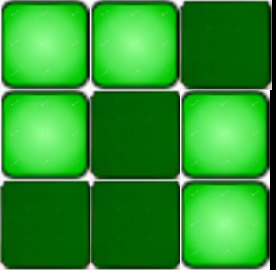

========== CLICKED ON (1, 0) ==========
Number of Lights On: 5


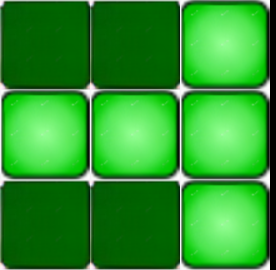

========== CLICKED ON (1, 1) ==========
Number of Lights On: 4


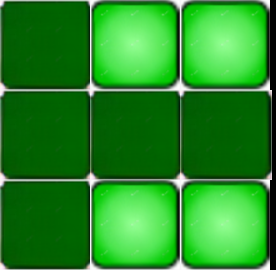

========== CLICKED ON (2, 0) ==========
Number of Lights On: 3


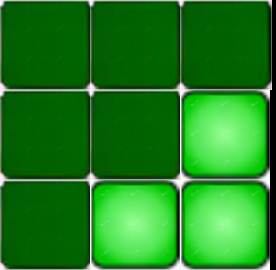

========== CLICKED ON (2, 2) ==========
Number of Lights On: 0


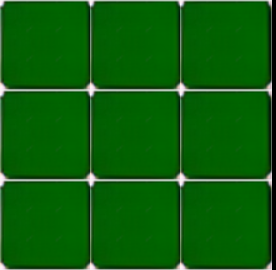

In [139]:
def solve_bfs(game: LightsOutGame):
    """ 
    Solving using BFS
    """
    memo_table = {}
    min_moves = float('inf')
    best_path = None
    hit = 0
    q = queue.Queue() # FIFO queue
    q.put(copy.deepcopy(game)) # put a deep copy of the game into the queue
    processed_count = 0

    while not q.empty():
        processed_count += 1
        curr_game_state: LightsOutGame = q.get()

        if processed_count % 1000 == 0:
            print("States iterated:", processed_count, len(memo_table))
            if best_path:
                print("Current best path:", best_path)
                print("Best path length:", min_moves)

        if curr_game_state.has_ended():
            if curr_game_state.get_num_of_clicks() < min_moves:
                min_moves = curr_game_state.get_num_of_clicks()
                best_path = curr_game_state.click_path
            break
        
        for i in range(curr_game_state._M):
            for j in range(curr_game_state._N):
                next_game_state = copy.deepcopy(curr_game_state)
                next_game_state.click(i, j)

                    # check if we have seen this state before
                if next_game_state.get_state_key() in memo_table:
                    hit += 1 # just to track how many times we see a previous cached position
                    cached_state_path = memo_table[next_game_state.get_state_key()]
                    if len(cached_state_path) < len(next_game_state.click_path):
                        next_game_state.click_path = cached_state_path
                    else:
                        # optimisation step to skip loops
                        memo_table[next_game_state.get_state_key()] = next_game_state.click_path
                        continue
                else: 
                    memo_table[next_game_state.get_state_key()] = next_game_state.click_path
            
                q.put(next_game_state)
       
    return min_moves, best_path, processed_count

ans = solve_bfs(game)
print("States explored:", ans[2])
print("Optimal min moves:", ans[0])
print("Optimal path found:", ans[1])
visualise_solution_path(game, ans[1])

## Uniform-Cost Search (UCS)

States iterated: 1000
States iterated: 2000
States iterated: 3000
States iterated: 4000
States iterated: 5000
States explored: 5602
Optimal min moves: 4
Optimal path found: [(1, 0), (1, 1), (2, 2), (2, 0)]
============ INITIAL STATE ============
Number of Lights On: 5


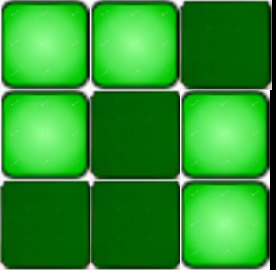

========== CLICKED ON (1, 0) ==========
Number of Lights On: 5


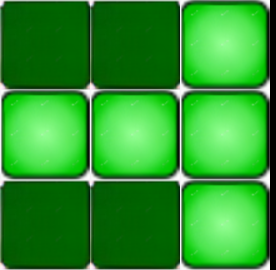

========== CLICKED ON (1, 1) ==========
Number of Lights On: 4


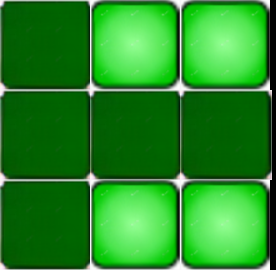

========== CLICKED ON (2, 2) ==========
Number of Lights On: 3


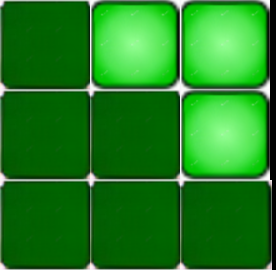

========== CLICKED ON (2, 0) ==========
Number of Lights On: 0


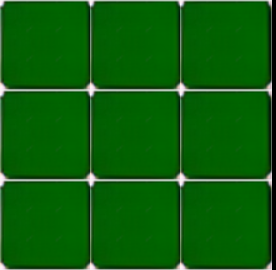

In [141]:
def solve_ucs(game: LightsOutGame):
    memo_table = {}

    min_moves = float('inf')
    best_path = None
    hit = 0
    priority_queue = [] # priority queue implemented as a heap
    
    setattr(LightsOutGame, "__lt__", lambda self, other: self.get_num_of_clicks() <= other.get_num_of_clicks())

    heapq.heappush(priority_queue, (0, copy.deepcopy(game))) # push a tuple of (priority, game_state) into the queue
    processed_count = 0

    while priority_queue:
        processed_count += 1
        _, curr_game_state = heapq.heappop(priority_queue)

        if processed_count % 1000 == 0:
            print("States iterated:", processed_count)            
            if best_path:
                print("Current best path:", best_path)
                print("Best path length:", min_moves)

        if curr_game_state.has_ended():
            if curr_game_state.get_num_of_clicks() < min_moves:
                min_moves = curr_game_state.get_num_of_clicks()
                best_path = curr_game_state.click_path
            break
        
        for i in range(curr_game_state._M):
            for j in range(curr_game_state._N):
                next_game_state = copy.deepcopy(curr_game_state)
                next_game_state.click(i, j)

                # check if we have seen this state before
                if next_game_state.get_state_key() in memo_table:
                    hit += 1 # just to track how many times we see a previous cached position
                    cached_state_path = memo_table[next_game_state.get_state_key()]
                    if len(cached_state_path) < len(next_game_state.click_path):
                        next_game_state.click_path = cached_state_path
                    else:
                        # optimisation step to skip loops
                        memo_table[next_game_state.get_state_key()] = next_game_state.click_path
                        continue
                else: 
                    memo_table[next_game_state.get_state_key()] = next_game_state.click_path
                
                heapq.heappush(priority_queue, (next_game_state.get_num_of_clicks(), next_game_state))
   
    return min_moves, best_path, processed_count

ans = solve_ucs(game)
print("States explored:", ans[2])
print("Optimal min moves:", ans[0])
print("Optimal path found:", ans[1])
visualise_solution_path(game, ans[1])

## Depth-First Search (DFS)

States iterated: 1000
States iterated: 2000
States explored: 2864
Optimal min moves: 4
Optimal path found: [(2, 0), (1, 1), (1, 0), (2, 2)]
============ INITIAL STATE ============
Number of Lights On: 5


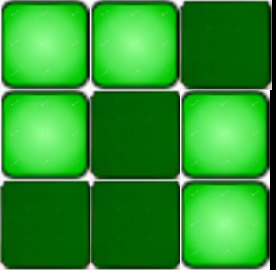

========== CLICKED ON (2, 0) ==========
Number of Lights On: 4


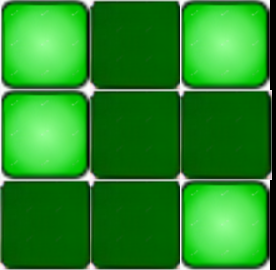

========== CLICKED ON (1, 1) ==========
Number of Lights On: 7


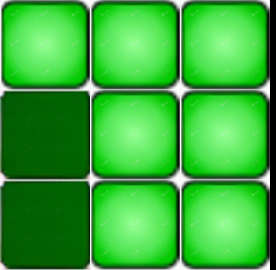

========== CLICKED ON (1, 0) ==========
Number of Lights On: 3


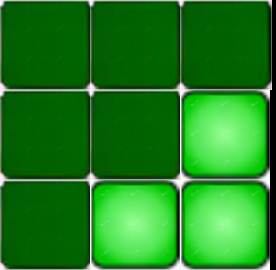

========== CLICKED ON (2, 2) ==========
Number of Lights On: 0


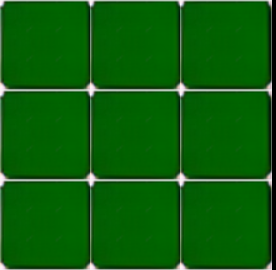

In [143]:
def solve_dfs(game: LightsOutGame):
    memo_table = {}

    min_moves = float('inf')
    best_path = None
    hit = 0
    stack = [] # LIFO stack
    stack.append(copy.deepcopy(game)) # put a deep copy of the game into the stack
    processed_count = 0

    while stack:
        processed_count += 1
        curr_game_state: LightsOutGame = stack.pop()

        if processed_count % 1000 == 0:                
            print("States iterated:", processed_count)
            if best_path:
                print("Current best path:", best_path)
                print("Best path length:", min_moves)

        if curr_game_state.has_ended():
            if curr_game_state.get_num_of_clicks() < min_moves:
                min_moves = curr_game_state.get_num_of_clicks()
                best_path = curr_game_state.click_path
            break
        
        for i in range(curr_game_state._M):
            for j in range(curr_game_state._N):
                next_game_state = copy.deepcopy(curr_game_state)
                next_game_state.click(i, j)

                # check if we have seen this state before
                if next_game_state.get_state_key() in memo_table:
                    hit += 1 # just to track how many times we see a previous cached position
                    cached_state_path = memo_table[next_game_state.get_state_key()]
                    if len(cached_state_path) < len(next_game_state.click_path):
                        next_game_state.click_path = cached_state_path
                    else:
                        # optimisation step to skip loops
                        memo_table[next_game_state.get_state_key()] = next_game_state.click_path
                        continue
                else: 
                    memo_table[next_game_state.get_state_key()] = next_game_state.click_path
            
                stack.append(next_game_state)
  
    return min_moves, best_path, processed_count

ans = solve_dfs(game)
print("States explored:", ans[2])
print("Optimal min moves:", ans[0])
print("Optimal path found:", ans[1])
visualise_solution_path(game, ans[1])

## Depth-Limited Search (DLS)

Searching to limit: 10
States iterated: 1000 453
States iterated: 2000 486
States explored: 2864
Optimal min moves: 4
Optimal path found: [(2, 0), (1, 1), (1, 0), (2, 2)]
============ INITIAL STATE ============
Number of Lights On: 5


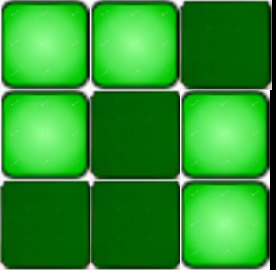

========== CLICKED ON (2, 0) ==========
Number of Lights On: 4


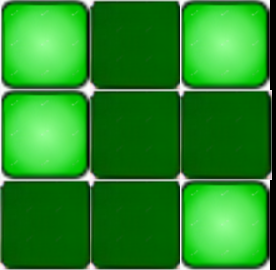

========== CLICKED ON (1, 1) ==========
Number of Lights On: 7


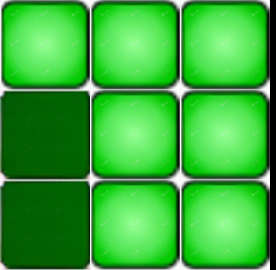

========== CLICKED ON (1, 0) ==========
Number of Lights On: 3


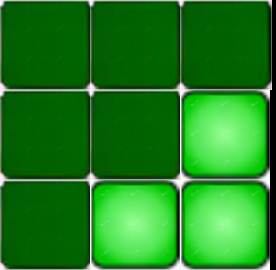

========== CLICKED ON (2, 2) ==========
Number of Lights On: 0


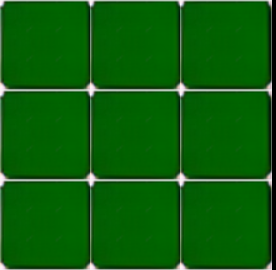

In [152]:
def solve_dls(game: LightsOutGame, depth_limit: int, memo_table=None):
    if not memo_table:
        memo_table = {}

    min_moves = float('inf')
    best_path = None
    hit = 0
    stack = [] # LIFO stack
    stack.append(copy.deepcopy(game)) # put a deep copy of the game into the stack with depth 0
    processed_count = 0

    print("Searching to limit:", depth_limit)
    while stack:
        processed_count += 1
        curr_game_state: LightsOutGame = stack.pop()
        curr_depth = curr_game_state.get_num_of_clicks()

        if processed_count % 1000 == 0:
            print("States iterated:", processed_count, len(memo_table))
            if best_path:
                print("Current best path:", best_path)
                print("Best path length:", min_moves)

        if curr_game_state.has_ended():
            if curr_game_state.get_num_of_clicks() < min_moves:
                min_moves = curr_game_state.get_num_of_clicks()
                best_path = curr_game_state.click_path
            break
        
        if curr_depth < depth_limit:
            for i in range(curr_game_state._M):
                for j in range(curr_game_state._N):
                    next_game_state = copy.deepcopy(curr_game_state)
                    next_game_state.click(i, j)

                    # check if we have seen this state before
                    if next_game_state.get_state_key() in memo_table:
                        hit += 1 # just to track how many times we see a previous cached position
                        cached_state_path = memo_table[next_game_state.get_state_key()]
                        if len(cached_state_path) < len(next_game_state.click_path):
                            next_game_state.click_path = cached_state_path
                        else:
                            # optimisation step to skip loops
                            memo_table[next_game_state.get_state_key()] = next_game_state.click_path
                            continue
                    else: 
                        memo_table[next_game_state.get_state_key()] = next_game_state.click_path
                
                    stack.append(next_game_state)

    return min_moves, best_path, processed_count


ans = solve_dls(game, depth_limit=10)
print("States explored:", ans[2])
print("Optimal min moves:", ans[0])
print("Optimal path found:", ans[1])
visualise_solution_path(game, ans[1])

## Iterative-Deepening Search (IDS)

Iterative searching to limit: 5
Searching to limit: 0
Searching to limit: 1
Searching to limit: 2
Searching to limit: 3
Searching to limit: 4
States explored: 734
Optimal min moves: 4
Optimal path found: [(1, 1), (1, 0), (2, 2), (2, 0)]
============ INITIAL STATE ============
Number of Lights On: 5


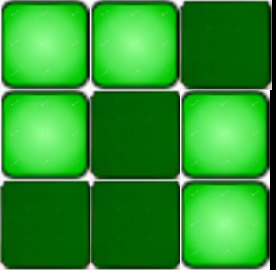

========== CLICKED ON (1, 1) ==========
Number of Lights On: 4


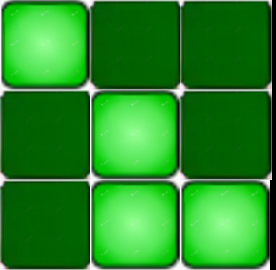

========== CLICKED ON (1, 0) ==========
Number of Lights On: 4


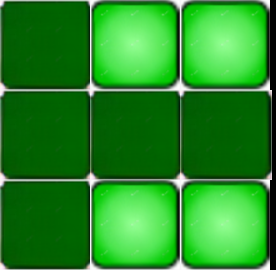

========== CLICKED ON (2, 2) ==========
Number of Lights On: 3


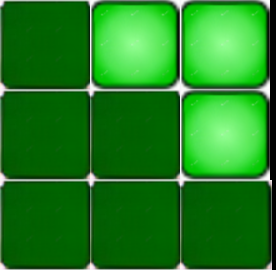

========== CLICKED ON (2, 0) ==========
Number of Lights On: 0


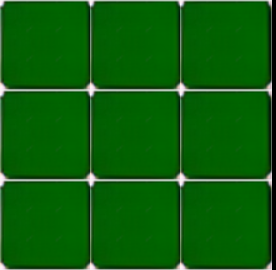

In [155]:
def solve_ids(game: LightsOutGame, max_depth: int):
    print("Iterative searching to limit:", max_depth)
    memo_table = {} # we can keep a single memo table for entire iterative deepening search
    for depth_limit in range(max_depth + 1):
        min_moves, best_path, processed_count = solve_dls(game, depth_limit, memo_table=memo_table)
        if best_path is not None:
            return min_moves, best_path, processed_count

    return float('inf'), None, processed_count


ans = solve_ids(game, max_depth=5)
print("States explored:", ans[2])
print("Optimal min moves:", ans[0])
print("Optimal path found:", ans[1])
visualise_solution_path(game, ans[1])

## Greedy Search

States explored: 235
Moves made: 14
Greedy path found: [(0, 0), (2, 2), (0, 2), (0, 1), (1, 0), (2, 0), (2, 2), (1, 2), (0, 2), (1, 1), (2, 2), (1, 2), (0, 1), (0, 0)]
============ INITIAL STATE ============
Number of Lights On: 5


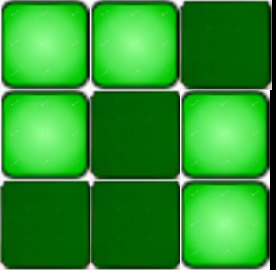

========== CLICKED ON (0, 0) ==========
Number of Lights On: 2


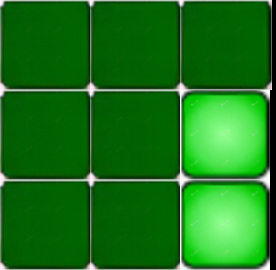

========== CLICKED ON (2, 2) ==========
Number of Lights On: 1


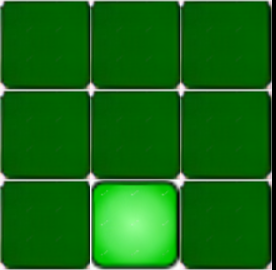

========== CLICKED ON (0, 2) ==========
Number of Lights On: 2


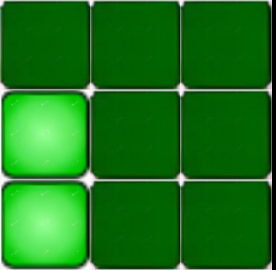

========== CLICKED ON (0, 1) ==========
Number of Lights On: 2


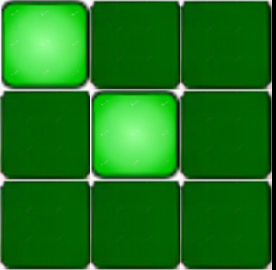

========== CLICKED ON (1, 0) ==========
Number of Lights On: 2


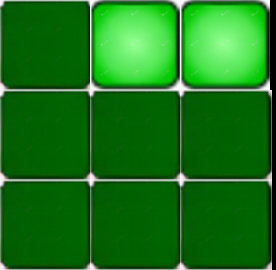

========== CLICKED ON (2, 0) ==========
Number of Lights On: 1


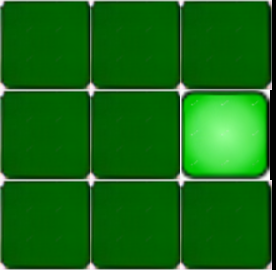

========== CLICKED ON (2, 2) ==========
Number of Lights On: 2


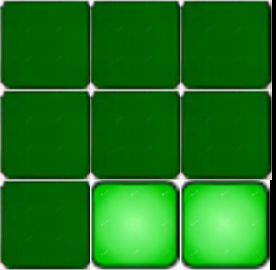

========== CLICKED ON (1, 2) ==========
Number of Lights On: 2


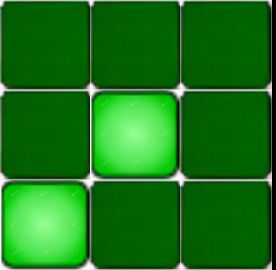

========== CLICKED ON (0, 2) ==========
Number of Lights On: 3


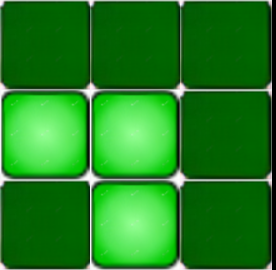

========== CLICKED ON (1, 1) ==========
Number of Lights On: 2


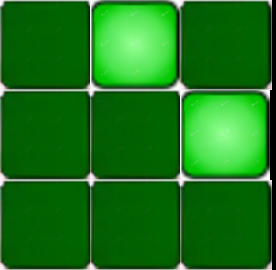

========== CLICKED ON (2, 2) ==========
Number of Lights On: 3


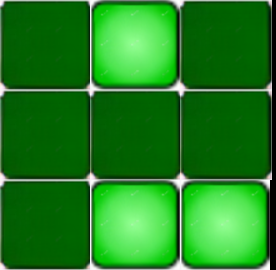

========== CLICKED ON (1, 2) ==========
Number of Lights On: 3


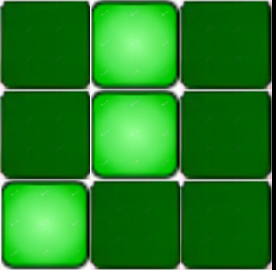

========== CLICKED ON (0, 1) ==========
Number of Lights On: 3


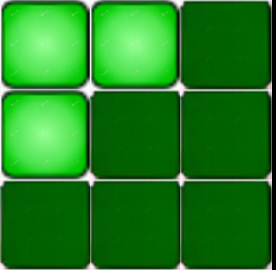

========== CLICKED ON (0, 0) ==========
Number of Lights On: 0


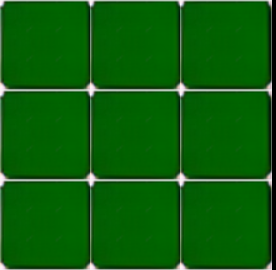

In [156]:
def solve_greedy(game: LightsOutGame):
    memo_table = {}

    min_moves = float('inf')
    best_path = None
    hit = 0
    priority_queue = [] # priority queue implemented as a heap

    setattr(LightsOutGame, "__lt__", lambda self, other: self.get_num_lights() <= other.get_num_lights())
    heapq.heappush(priority_queue, (game.get_num_lights(), copy.deepcopy(game))) # push a tuple of (priority, game_state) into the queue
    processed_count = 0

    while priority_queue:
        processed_count += 1
        _, curr_game_state = heapq.heappop(priority_queue)

        if processed_count % 1000 == 0:
            print("States iterated:", processed_count)
            if best_path:
                print("Current best path:", best_path)
                print("Best path length:", min_moves)

        if curr_game_state.has_ended():
            if curr_game_state.get_num_of_clicks() < min_moves:
                min_moves = curr_game_state.get_num_of_clicks()
                best_path = curr_game_state.click_path
            break
        
        for i in range(curr_game_state._M):
            for j in range(curr_game_state._N):
                next_game_state = copy.deepcopy(curr_game_state)
                next_game_state.click(i, j)

                # check if we have seen this state before
                if next_game_state.get_state_key() in memo_table:
                    hit += 1 # just to track how many times we see a previous cached position
                    cached_state_path = memo_table[next_game_state.get_state_key()]
                    if len(cached_state_path) < len(next_game_state.click_path):
                        next_game_state.click_path = cached_state_path
                    else:
                        # optimisation step to skip loops
                        memo_table[next_game_state.get_state_key()] = next_game_state.click_path
                        continue
                else: 
                    memo_table[next_game_state.get_state_key()] = next_game_state.click_path
                
                heapq.heappush(priority_queue, (next_game_state.get_num_lights(), next_game_state))
     
    return min_moves, best_path, processed_count

ans = solve_greedy(game)
print("States explored:", ans[2])
print("Moves made:", ans[0])
print("Greedy path found:", ans[1])
visualise_solution_path(game, ans[1])

## A*Star Search (BFS)

States explored: 45
Moves made: 4
A*Star path found: [(2, 2), (1, 1), (1, 0), (2, 0)]
============ INITIAL STATE ============
Number of Lights On: 5


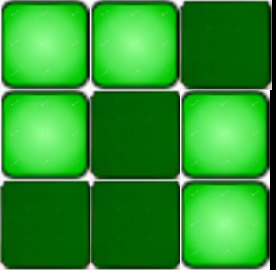

========== CLICKED ON (2, 2) ==========
Number of Lights On: 4


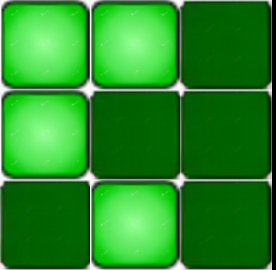

========== CLICKED ON (1, 1) ==========
Number of Lights On: 3


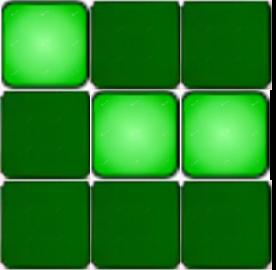

========== CLICKED ON (1, 0) ==========
Number of Lights On: 3


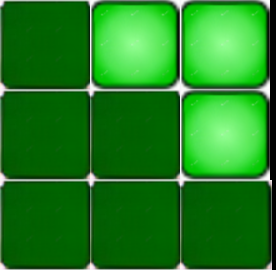

========== CLICKED ON (2, 0) ==========
Number of Lights On: 0


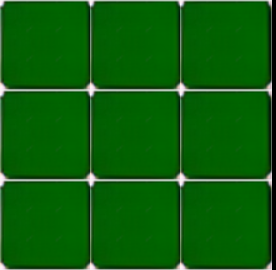

In [157]:
def solve_astar(game: LightsOutGame):
    memo_table = {}
    
    min_moves = float('inf')
    best_path = None
    hit = 0
    priority_queue = [] # priority queue implemented as a heap
    setattr(LightsOutGame, "__lt__", lambda self, other: self.get_num_lights() <= other.get_num_lights())
    heapq.heappush(priority_queue, (game.get_num_lights(), copy.deepcopy(game))) # push a tuple of (priority, game_state) into the queue
    processed_count = 0

    while priority_queue:
        processed_count += 1
        _, curr_game_state = heapq.heappop(priority_queue)

        if processed_count % 1000 == 0:
            print("States iterated:", processed_count, len(memo_table))
            if best_path:
                print("Current best path:", best_path)
                print("Best path length:", min_moves)

        if curr_game_state.has_ended():
            if curr_game_state.get_num_of_clicks() < min_moves:
                min_moves = curr_game_state.get_num_of_clicks()
                best_path = curr_game_state.click_path
            break
        
        for i in range(curr_game_state._M):
            for j in range(curr_game_state._N):
                next_game_state = copy.deepcopy(curr_game_state)
                next_game_state.click(i, j)

                # check if we have seen this state before
                if next_game_state.get_state_key() in memo_table:
                    hit += 1 # just to track how many times we see a previous cached position
                    cached_state_path = memo_table[next_game_state.get_state_key()]
                    if len(cached_state_path) < len(next_game_state.click_path):
                        next_game_state.click_path = cached_state_path
                    else:
                        # optimisation step to skip loops
                        memo_table[next_game_state.get_state_key()] = next_game_state.click_path
                        continue
                else: 
                    memo_table[next_game_state.get_state_key()] = next_game_state.click_path
                
                # priority for A* is the sum of the cost to reach the current state and the heuristic value using both num of clicks and num of lights
                total_cost = next_game_state.get_num_of_clicks() + next_game_state.get_num_lights()
                heapq.heappush(priority_queue, (total_cost, next_game_state))
   
    return min_moves, best_path, processed_count


ans = solve_astar(game)
print("States explored:", ans[2])
print("Moves made:", ans[0])
print("A*Star path found:", ans[1])
visualise_solution_path(game, ans[1])